

# Fourier Analysis in NT and Markets

In this warmup notebook, we compare the application of Fourier series analysis in Number Theory and market data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, signal
from math import log

In [2]:
def von_Mangoldt(N):
    #Return an np.arrey Lambda[0,1,...,N], where Lambda is a simplified von mangoldt function, taking log value on primes. With the convention \Lambda(0)=0
    Lam=np.zeros(N, dtype=float)
    is_prime=np.ones(N+1, dtype=bool)

    for p in range(2, N):
        if not is_prime[p]:
            continue
        is_prime[p*p::p]=0
        Lam[p]=log(p)
    return Lam

By the Prime-Number Theorem, the sum of von Mangoldt up to N should be around N.

In [3]:
N=9699690 #Chosing primorial, to make the effect of small prime divisor of frequency denominator better visible.

Lambda=von_Mangoldt(N)
print("N:", N, "sum Lambda:", Lambda.sum())

N: 9699690 sum Lambda: 9696470.977783006


We next calculate $\hat{\Lambda}(\alpha)=\sum_{n\leq N}\Lambda(n) e^{2\pi i \alpha n}$

In [4]:
def hat(Array):
    #Simple fft that return alpha value and fourier transform. No padding or hann window.
    N=len(Array)
    alphas=np.arange(N)/N
    X=fftpack.fft(Array)
    return alphas, X

alphas, X=hat(Lambda)

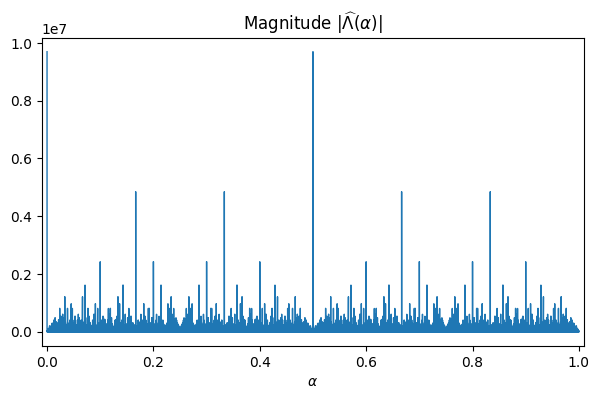

In [5]:
def plot_spectrum(alphas, X, zoom_max=0.1, logscale=False):
    mag=np.abs(X)
    plt.figure(figsize=(7,4))
    plt.plot(alphas, mag, lw=1)
    plt.xlim(-0.01, 1.01)
    plt.xlabel(r'$\alpha$')
    plt.title(r'Magnitude $|\widehat{\Lambda}(\alpha)|$')
    plt.show()

plot_spectrum(alphas, X, zoom_max=0.05)

We know that $|\hat{\Lambda}(\alpha)|$ should be of size $N/q$ if $\alpha$ is close to a rational number with denominator $q$. Let's extract this information numerically.

In [6]:

def large_spec(alphas, X, rel_size=0.01):
    mag=np.abs(X)
    thresh = rel_size * float(mag.max())
    large= mag > thresh
    padded=np.r_[0, large.view(np.int8), 0] #reinterpret as int values, and add 0 at beginning and end
    diff= np.diff(padded)  #Differentiate to discover runs
    starts= np.where(diff == 1)[0]
    ends= np.where(diff == -1)[0]
    sel_indices = []
    for s, e in zip(starts, ends):
        # choose index of max magnitude inside cluster
        cluster_idx = np.arange(s, e)
        local_idx = cluster_idx[np.argmax(mag[cluster_idx])]
        sel_indices.append(int(local_idx))
    sel_indices = np.array(sel_indices, dtype=int)
    order = np.argsort(-np.abs(X[sel_indices]))
    sel_indices = sel_indices[order]
    return alphas[sel_indices], X[sel_indices]


largalpha, largeX= large_spec(alphas, X)

np.float64(0.21428571428571427)

Testing some values:

In [7]:

print(np.abs(largeX))
print(largeX)
print(largalpha[10])
print(largeX[10])

[9696470.97778301 9696469.59148865 4848234.53301099 ...   96966.52359202
   96965.16138097   96965.16138097]
[ 9696470.97778301   -0.j         -9696469.59148865   -0.j
 -4848233.84097307-2590.42927649j ...   -96840.79135241+4936.37800022j
    96839.44400488-4936.05170785j    96839.44400488+4936.05170785j]


We extract next a physical space approximant that capture behaviours at large Fourier frequencies, via
$$\Lambda_{\approx}=\Lambda*K(n),$$
where
$$K(n)=\sum_{\alpha \in \mathcal{S}} e(\alpha n)\frac{1_{|n|\leq L}}{2L+1}.$$

Since physical space convolution requires $LN\approx N^2$ steps, it is not feasible, instead we use multiplication in frequency space and inverse Fourier.

In [14]:
def L_approx(Lambda=Lambda, largalpha=largalpha, R=10, scale=0.1):
    def _next_pow2(x):
        x = int(x)
        if x <= 1:
            return 1
        return 1 << ((x - 1).bit_length())

    N = Lambda.shape[0]
    Y = min(int(R), len(largalpha))

    ZN = int(np.floor(scale * N))
    if ZN < 0:
        ZN = 0

    alphas = np.array(largalpha[:Y], dtype=float)  # selected alphas
    Klen = 2 * ZN + 1                              # kernel length (t = -ZN..ZN)

    if Y == 0 or Klen == 0:
        return np.zeros(N, dtype=float)

    # build kernel time samples K_time[t] = sum_alpha e(2π i alpha * t) for t=-ZN..ZN
    t = np.arange(-ZN, ZN + 1)                     # length Klen
    K_time = np.exp(2j * np.pi * np.outer(alphas, t)).sum(axis=0).astype(np.complex128)

    # linear convolution: required output length L = N + Klen - 1
    L = N + Klen - 1
    M = _next_pow2(L)                              # FFT size (>= L)

    # use complex FFTs because K_time is complex
    A = np.fft.fft(Lambda, n=M)
    B = np.fft.fft(K_time, n=M)
    conv_full = np.fft.ifft(A * B, n=M).real[:L]   # linear convolution result (real)

    # 'same' slice: align t=0 with index ZN -> take conv_full[ZN:ZN+N]
    start = ZN
    end = ZN + N
    conv_same = conv_full[start:end]

    # counts (averaging divisor): convolution of ones(N) with ones(Klen) via FFT
    ones_N = np.ones(N, dtype=float)
    ones_K = np.ones(Klen, dtype=float)
    C = np.fft.ifft(np.fft.fft(ones_N, n=M) * np.fft.fft(ones_K, n=M), n=M).real[:L]
    counts = C[start:end]
    counts[counts == 0] = 1.0

    Lapprox = conv_same / counts
    return Lapprox

Lapprox = L_approx(Lambda, largalpha, R=20)


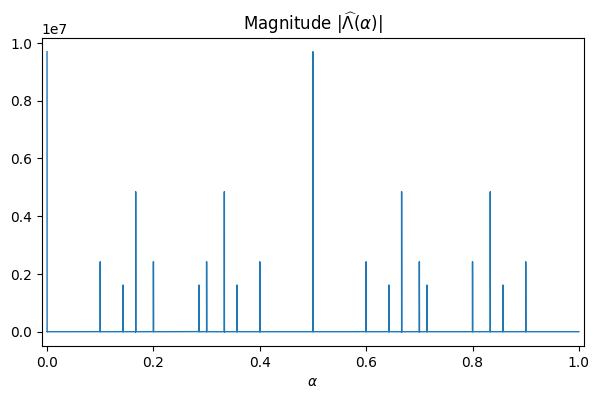

In [15]:
alphas1, X1 =hat(Lapprox)
plot_spectrum(alphas1, X1, zoom_max=0.05)